# ElasticSearch 검색 엔진을 통한 문서 데이터를 색인 및 반환

### 빅데이터와 정보검색 - 임희석 교수님
##### 고려대학교 컴퓨터정보통신대학원 빅데이터융합학과
##### 이동환(2019512014) / 김의순(2019512005)

**시스템 구성**

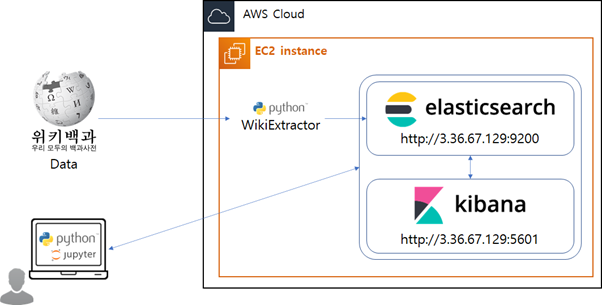

### <사전 작업>
#### 1. AWS EC2 Instance 생성
#### 1) EC2 Instance에 Elasticsearch(http://3.36.67.129:9200) 설치 및 실행
#### 2) EC2 Instance에 Kibana(http://3.36.67.129:5601) 설치 및 실행

In [1]:
!git clone https://github.com/tarje2/BDC_IR.git

Cloning into 'BDC_IR'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 150 (delta 2), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (150/150), 35.62 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
!pip install elasticsearch

     |████████████████████████████████| 348kB 2.8MB/s 


### 1. ElasticSearch 연동 및 확인

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

In [4]:
es = Elasticsearch('http://3.36.67.129:9200')
es.info()

{'cluster_name': 'Wilshere_ES',
 'cluster_uuid': 'e8ZntsY7R7CEZnj8Odv-Rw',
 'name': 'Wilshere_Elasticsearch',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2021-04-20T20:56:39.040728659Z',
  'build_flavor': 'default',
  'build_hash': '3186837139b9c6b6d23c3200870651f10d3343b7',
  'build_snapshot': False,
  'build_type': 'tar',
  'lucene_version': '8.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1',
  'minimum_wire_compatibility_version': '6.8.0',
  'number': '7.12.1'}}

### 2. ElasticSearch 에 index 생성

In [5]:
# 데이터를 색인화하기 위한 함수
def indexing(es, index_name):
    # 이미 존재할 경우 삭제하고 다시 만들기
    if es.indices.exists(index=index_name):
        es.indices.delete(index=index_name)

    # 인덱스 생성
    print(es.indices.create(index=index_name))

In [6]:
# 인덱스명을 정하기 (자유롭게)
index_name = 'kowiki'
indexing(es, index_name)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'kowiki'}


##### 추가) Kibana에서 확인하려면 생성한 index명에 맞는 index pattern 생성

In [7]:
!pip install xmltodict

### 3. ElasticSearch 에 데이터 적재(인덱싱)

In [ ]:
import os
import xml.etree.ElementTree as ET
import json, codecs
import xmltodict
from collections import OrderedDict

path = 'BDC_IR/extract_result_kowiki_latest/AA/'
file_list = os.listdir(path)

#print(file_list[0])
for i in range(len(file_list)):
    fr = open('BDC_IR/extract_result_kowiki_latest/AA/'+file_list[i],'r',encoding="utf-8")
    data = fr.read()
    data = "<html>" + data
    data = data + "</html>"

    result = xmltodict.parse(data)
    dictionary = json.loads(json.dumps(result))
    #print(dictionary)
    #print(len(dictionary['html']['doc']))
    temp = OrderedDict()
    for j in range(len(dictionary['html']['doc'])):
        temp['id'] = dictionary['html']['doc'][j]['@id']
        temp['url'] = dictionary['html']['doc'][j]['@url']
        temp['title'] = dictionary['html']['doc'][j]['@title']
        temp['text'] = dictionary['html']['doc'][j]['#text']
        
        sample = json.dumps(temp, ensure_ascii=False)
        #print(sample)
        es.index(index=index_name, doc_type='string', body = sample)

es.indices.refresh(index=index_name)

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in document index requests is deprecated, use the typeless endpoints instead (/{index}/_doc/{id}, /{index}/_doc, or /{index}/_create/{id}).
  warnings.warn(message, category=ElasticsearchWarning)


In [ ]:
#AA/AB/AC/AD/AE/AF

### 4. ElasticSearch 에 적재된 데이터 검색

In [ ]:
results = es.search(index=index_name, body={'from':0, 'size':5, 'query':{'match':{'text':'정치'}}})
for result in results['hits']['hits']:
    print('score:', result['_score'], 'source:', result['_source'])

score: 9.424063 source: {'id': '642085', 'url': 'https://ko.wikipedia.org/wiki?curid=642085', 'title': '정치 부패', 'text': '정치 부패\n\n정치 부패(政治腐敗)는 정치에 종사하는 사람들이 권력의 사용으로 불법적이며 사사적인 이익을 추구하는 행위를 말한다. 정적의 억압이나 경찰로 인한 탄압과 같은 정부의 권력을 다른 목적으로 악용하는 행위는 정치 부패로 간주하지 않다. 정부와 직접적으로 관련이 없는 민간인이나 사기업도 정치 부패로 간주하지 않다. 정치 부패는 즉 정치를 수행하는 정치인의 불법 행위이다. 정치 부패의 형태는 뇌물, 연고주의, 공갈, 정실인사, 네포티즘, 불법 후원, 공금 횡령 등이 있다. 이러한 형태의 정치 부패는 마약거래, 돈세탁, 인신매매 등의 조직범죄에 연류될 수 있다. 정치 부패가 심한 상황을 도둑정치(Kleptocracy)라고 부른다.'}
score: 9.344169 source: {'id': '170322', 'url': 'https://ko.wikipedia.org/wiki?curid=170322', 'title': '나라별 정치 상황', 'text': "나라별 정치 상황\n\n이 문서는 한국어 위키백과의 나라 목록에 실린 나라 중 독립국을 대상으로 '오늘날의 나라별 정치 상황'을 간략히 정리한 것이다. 보다 자세한 나라별 정치 상황은 해당 국가의 정치 상황 문서를 참조할 것."}
score: 9.129847 source: {'id': '862548', 'url': 'https://ko.wikipedia.org/wiki?curid=862548', 'title': '독일 정치 교육', 'text': '독일 정치 교육\n\n #넘겨주기 독일의 정치 교육'}
score: 9.0529585 source: {'id': '1052202', 'url': 'https://ko.wikipedia.org/wiki?curid=1052202', 'title': '정